**Created by Muhammed El-Yamani**

**🚀 Clothing type classifier Techsquadeg**

**15 Jun 2022**


# Problem Statment

Assume that we would like to create **a clothing type classifier**. 

You are required to select one of the **freely available datasets** and **create an initial model** to deliver a prototype of the solution. 

It’s recommended to use google colab for this task since it’s free and easily shareable. 

**Deliverables:**


1. A Github repository containing your solution

2. A ReadMe detailing the steps you took to solve the problem, your approach, your data handling techniques, any problems you faced, and the results of your tests.

3. A summary of the results and metrics you choose to evaluate

4. A presentation to illustrate your results (will be discussed during the evaluation process)


-----------------------------------------------------
 



**Notes:**


1.   Use proper data handling and data loading: Done 

2.   Explore multiple solutions and showcase why you chose the final one
Be clear on your choice of metrics and why you chose them.

3. Make sure to write clean, modular, and well-documented code.: Done 

4. Make sure to keep your approach optimum as much as possible for deployment, with minimal model size and the number of FLOPS.


You are not expected to reach optimal results, but it is very critical for you to showcase how you approach the problem and outline your thought process.


Best of luck


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/jobs_assignments/techsquadeg

## Import libraries

In [2]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
import json
from tqdm import tqdm
import logging
from pathlib import Path
from torch.utils.data import Dataset
import re
import pandas as pd
import csv
import os
import pathlib
from tqdm import tqdm
from torchvision import datasets
import shutil
from collections import Counter
import matplotlib as mpl
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12) 
%matplotlib inline


mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

/home/muhammed/anaconda3/envs/data-science/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# helper files
import helper

# from utils.dice_score import dice_loss
# from evaluate import evaluate
# from unet import UNet
# from utils.utils import plot_test_sample
# from net_utility import Net_Utility
# from utils.load_dataset import JawsDataset, transform_data_entry, axial_dataset_train, coronal_dataset_train, sagittal_dataset_train, axial_dataset_test, coronal_dataset_test, sagittal_dataset_test


## Global variables

In [4]:
LOCAL_DATASET_PATH='dataset'
LOCAL_RAW_DATASET_PATH = 'source_dataset'
GENERATE_IMAGES=False

In [5]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
MULTIPLE_TRAIN_SIZE = 2
LOADER_ARGS = dict(batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# EPOCHS = 5
EPOCHS = 1
LEARNING_RATE = 1e-5
TRAIN = True
print(f'Using device {DEVICE}')

Using device cuda


## Preparing Datasets

- source_dataset/Anno_coarse/
  - list_category_cloth.txt
  - list_category_img.txt

- source_dataset/Eval
  - list_eval_partition.txt

- source_dataset/Img
  - img.zip

In [6]:
def preperare_csv_files(source_dataset, dataset_path):
  if not os.path.isdir(f"{LOCAL_DATASET_PATH}"):
    os.mkdir(f"{LOCAL_DATASET_PATH}")

  data= dict()
  if not os.path.isfile(f'{dataset_path}/list_eval_partition.csv'):
    list_eval_partition_file = f'{source_dataset}/Eval/list_eval_partition.txt'
    list_eval_partition_df = pd.read_csv(list_eval_partition_file, skiprows=1,  delim_whitespace=True)
    list_eval_partition_df.to_csv(f'{dataset_path}/list_eval_partition.csv', sep=',', index=False)
  data['list_eval_partition'] = pd.read_csv(f'{LOCAL_DATASET_PATH}/list_eval_partition.csv')

  if not os.path.isfile(f'{dataset_path}/list_category_cloth.csv'):
    list_category_cloth_file = f'{source_dataset}/Anno_coarse/list_category_cloth.txt'
    list_category_cloth_df = pd.read_csv(list_category_cloth_file, skiprows=1,  delim_whitespace=True)
    list_category_cloth_df.to_csv(f'{dataset_path}/list_category_cloth.csv', sep=',', index=False)
  data['list_category_cloth'] = pd.read_csv(f'{LOCAL_DATASET_PATH}/list_category_cloth.csv')

  if not os.path.isfile(f'{dataset_path}/list_category_img.csv'):
    list_category_img_file = f'{source_dataset}/Anno_coarse/list_category_img.txt'
    list_category_img_df = pd.read_csv(list_category_img_file, skiprows=1,  delim_whitespace=True)
    list_category_img_df.to_csv(f'{dataset_path}/list_category_img.csv', sep=',', index=False)
  data['list_category_img'] = pd.read_csv(f'{LOCAL_DATASET_PATH}/list_category_img.csv')

  return data


In [7]:
data = preperare_csv_files(LOCAL_RAW_DATASET_PATH, LOCAL_DATASET_PATH)

In [8]:
def prepare_images(source_dataset_path, dataset_path, generate_images=True, extract=False):
  if generate_images:
    category = dict()

    data = preperare_csv_files(source_dataset_path, dataset_path)
    for split in ['train', 'val', 'test']:
      pathlib.Path(f'{dataset_path}/images_v2/{split}').mkdir(parents=True, exist_ok=True)
    df_split=data['list_eval_partition']
  
    path_imgs=f'{source_dataset_path}/Img/img.zip'
    if extract:
      with zipfile.ZipFile(path_imgs, 'r') as zf:
           for member in tqdm(zf.infolist(), desc='Extracting '):
               try:
                   zf.extract(member, f"{dataset_path}/imgs_v2")
               except zipfile.error as e:
                   pass
    for i in tqdm(range(df_split.shape[0]), desc="Copying images "):
      local_image_path=df_split.iloc[i]['image_name']
      split=df_split.iloc[i]['evaluation_status']
      image_path=f'{f"{dataset_path}/imgs_v2"}/{local_image_path}'

      folder_name, image_name = image_path.split('/')[3:]
      category_name = folder_name.split('_')[-1]
      if category_name in category:
        if split in category[category_name]:
           category[category_name][split] +=1
        else:
          category[category_name][split] = 1
      else:
          category[category_name]=dict()
          category[category_name][split] = 1
      n = category[category_name][split]
      image_name_updated = f'img_{str(n).zfill(8)}.jpg'
      pathlib.Path(f'{dataset_path}/images_v2/{split}/{category_name}').mkdir(parents=True, exist_ok=True)


      new_image_path = f"{dataset_path}/images_v2/{split}/{category_name}/{image_name_updated}"

      shutil.copyfile(image_path, new_image_path)

In [9]:
prepare_images(LOCAL_RAW_DATASET_PATH, LOCAL_DATASET_PATH, GENERATE_IMAGES)

Copying images : 100%|██████████| 289222/289222 [23:57<00:00, 201.19it/s] 


Notes README.md from source_dataset:
1. The long side of images are resized to 300;
2. The aspect ratios of original images are kept unchanged.

## Data loaders 

- transforms
- augmentation

In [10]:
def get_data(dataset_path, image_size, split, shuffle=True, loader_args= dict(batch_size=16, num_workers=4, pin_memory=True)):
  '''
  split: train | val | test
  '''
  data_dir = f'{dataset_path}/images_v2/{split}'
  if split == 'train':

    dataset_transform = transforms.Compose([
    transforms.RandomOrder([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1), ratio=(0.8, 1.2), interpolation=transforms.InterpolationMode.BICUBIC)
        ]),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  else:
    dataset_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  dataset = datasets.ImageFolder(data_dir, transform=dataset_transform)
  print(f'{split} dataset: {len(dataset)} images')
  print("#"*50)
  dataloader = torch.utils.data.DataLoader(dataset, shuffle=shuffle, **loader_args)
  
  return dataset, dataset_transform, dataloader

In [11]:
dataloaders= dict()
image_datasets= dict()
data_transforms= dict()
train_dataset, train_dataset_transform, train_dataloader= get_data(LOCAL_DATASET_PATH, IMAGE_SIZE, 'train', shuffle=True, loader_args=LOADER_ARGS)
val_dataset, val_dataset_transform, val_dataloader= get_data(LOCAL_DATASET_PATH, IMAGE_SIZE, 'val', shuffle=True, loader_args=LOADER_ARGS)
test_dataset, test_dataset_transform, test_dataloader= get_data(LOCAL_DATASET_PATH, IMAGE_SIZE, 'test', shuffle=True, loader_args=LOADER_ARGS)

train dataset: 209222 images
##################################################
val dataset: 40000 images
##################################################
test dataset: 40000 images
##################################################


In [12]:
image_datasets={'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
dataloaders={'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

In [13]:
classes_names = image_datasets['train'].classes
print("number of classes in train datasets: ", len(classes_names))

number of classes in train datasets:  46


In [14]:
print("number of classes in val datasets: ", len(image_datasets['val'].classes))

number of classes in val datasets:  46


In [15]:
print("number of classes in tes datasets: ", len(image_datasets['test'].classes))

number of classes in tes datasets:  46


## Explore The Dataset

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Explore The Datase:</u></b><br>
 
* <i>RGB images</i><br>
* <i>train dataset: 209222 images</i><br>
* <i>val dataset: 40000 images</i><br>
* <i>test dataset: 40000 images </i><br>
* <i>Classes: 46 </i><br>
* <i>The classes not balanced with skewed graph </i><br>
* <i>The class **Dress** has the greatest size with **52138**  </i><br>
* <i>The class **Halter** has the lowest size with **11**  </i><br>



**Solution for imbalanced**

We can solve this problem by making augmentation to generate more datasets for the classes with the weights of their distribution.


We have 52138 images for Dress. So the new data will be 52138*46 ~ 2.4e6. 

**The advantages:**

- The model will not be biased towards some classes and perhaps we get better results.

From 2.1e4   to   2.4e6.

I will let this approach for future works.

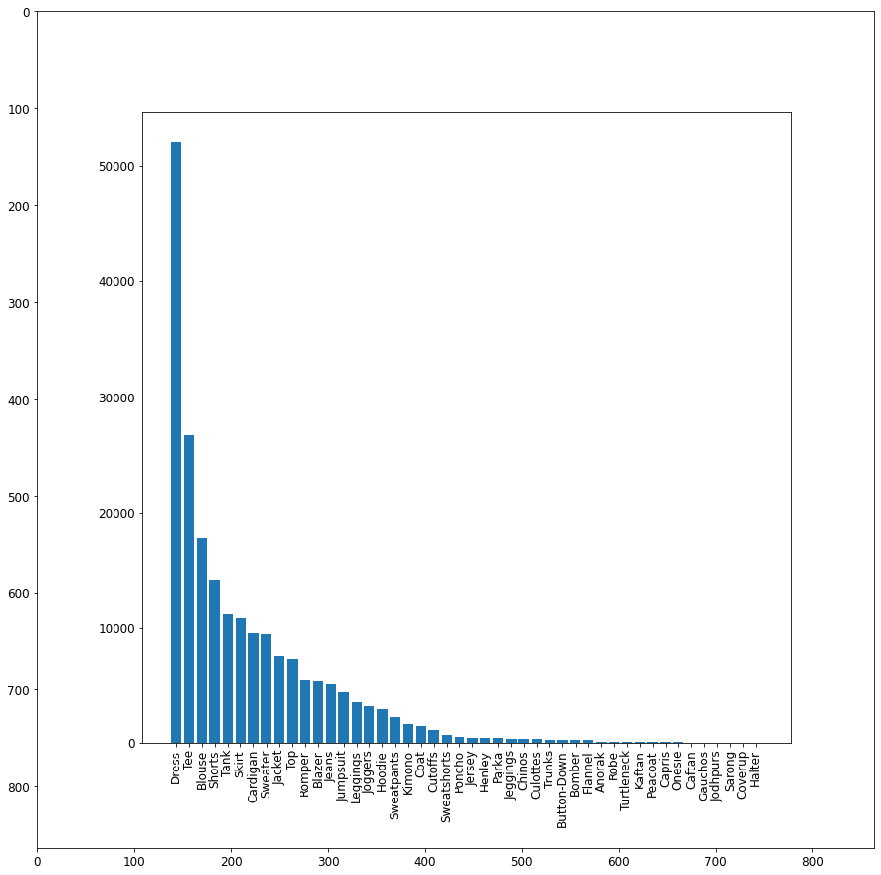

In [19]:
from PIL import Image

if not os.path.isfile('freq_classes_train.png'):
  train_dir = f'{LOCAL_DATASET_PATH}/images_v2/train/**/*'
  list_paths = glob.glob(train_dir)
  list__categories = [path.split('/')[-2] for path in list_paths]
  freq_classes_train = Counter(list__categories).most_common()
  x, y = zip(*freq_classes_train)
  plt.figure(figsize=[12, 12])
  plt.bar(x, y)
  plt.xticks(rotation =90)
  plt.savefig('freq_classes_train.png')
  plt.show()

else: 
  img = Image. open('freq_classes_train.png')
  plt.imshow(img) 



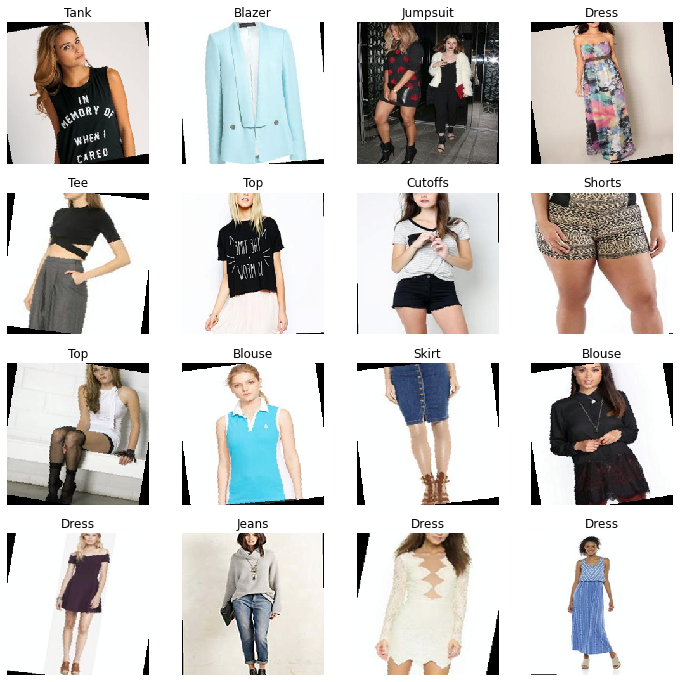

In [17]:
train_data_iter = iter(dataloaders['train'])
batch = train_data_iter.next()
images, labels = batch
plt.figure(figsize=(12, 12))
for index in range(0, min(16, len(images))):
    ax = plt.subplot(4, 4, index + 1)
    helper.imshow(images[index], ax=ax, title =classes_names[labels[index]] , normalize=True)



## Training

### <span style="color:#e76f51;">References</span>

- <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf">DeepFashion: Powering Robust Clothes Recognition and Retrieval with Rich Annotations, CVPR 2016</a>


- Transfere learning on vgg/resnet/...
- Build small custom cnn

## Testing

## Evaluation

## Visualiaztion